
# CPE 313 : Advanced Machine Learning with Deep Learning
## HOA 1.1 Using Tensorflow with a Real Dataset

*   Name: Abo, Emmanuel

---



# Linear Regression with a Real Dataset

This Colab uses a real dataset to predict the prices of houses in California.   






## Learning Objectives:

After doing this Colab, you'll know how to do the following:

* Demonstrate csv file manipulation using Pandas.
* Examine a given data.
* Experiment with different features in building a model.
* Demonstrate tuning a model's hyperparameters.

## The Dataset
  
The [dataset for this exercise](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) is based on 1990 census data from California. The dataset is old but still provides a great opportunity to learn about machine learning programming.

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [1]:
#@title Import relevant modules
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

## The dataset

Datasets are often stored on disk or at a URL in [.csv format](https://wikipedia.org/wiki/Comma-separated_values).

A well-formed .csv file contains column names in the first row, followed by many rows of data.  A comma divides each value in each row. For example, here are the first five rows of the .csv file holding the California Housing Dataset:

```
"longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"
-114.310000,34.190000,15.000000,5612.000000,1283.000000,1015.000000,472.000000,1.493600,66900.000000
-114.470000,34.400000,19.000000,7650.000000,1901.000000,1129.000000,463.000000,1.820000,80100.000000
-114.560000,33.690000,17.000000,720.000000,174.000000,333.000000,117.000000,1.650900,85700.000000
-114.570000,33.640000,14.000000,1501.000000,337.000000,515.000000,226.000000,3.191700,73400.000000
```



### Load the .csv file into a pandas DataFrame

This Colab, like many machine learning programs, gathers the .csv file and stores the data in memory as a pandas Dataframe.  Pandas is an open source Python library.  The primary datatype in pandas is a DataFrame.  You can imagine a pandas DataFrame as a spreadsheet in which each row is identified by a number and each column by a name. Pandas is itself built on another open source Python library called NumPy. If you aren't familiar with these technologies, please view these two quick tutorials:

*   [NumPy](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/numpy_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=numpy_tf2-colab&hl=en)
*   [Pandas DataFrames](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en)

The following code cell imports the .csv file into a pandas DataFrame and scales the values in the label (`median_house_value`):

In [2]:
# Import the dataset.
training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

# Scale the label.
training_df["median_house_value"] /= 1000.0

# Print the first rows of the pandas DataFrame.
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


Scaling `median_house_value` puts the value of each house in units of thousands. Scaling will keep loss values and learning rates in a friendlier range.  

Although scaling a label is usually *not* essential, scaling features in a multi-feature model usually *is* essential.

## Examine the dataset

A large part of most machine learning projects is getting to know your data. The pandas API provides a `describe` function that outputs the following statistics about every column in the DataFrame:

* `count`, which is the number of rows in that column. Ideally, `count` contains the same value for every column.

* `mean` and `std`, which contain the mean and standard deviation of the values in each column.

* `min` and `max`, which contain the lowest and highest values in each column.

* `25%`, `50%`, `75%`, which contain various [quantiles](https://developers.google.com/machine-learning/glossary/#quantile).

In [3]:
# Get statistics on the dataset.
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


### Task 1: Identify anomalies in the dataset

Do you see any anomalies (strange values) in the data?

> The values of some columns are significantly higher than other quantiles.

## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass.

Since you don't need to understand model building code right now, we've hidden this code cell.  You may optionally double-click the following headline to see the code that builds and trains a model.

In [4]:
def build_and_compile_model(learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1, input_shape=(1,))
    ])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model


def train_model(model, df, feature, label, epochs, batch_size):
  history = model.fit(x=df[feature], y=df[label], batch_size=batch_size, epochs=epochs)
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

## Define plotting functions

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve

You may optionally double-click the headline to see the matplotlib code, but note that writing matplotlib code is not an important part of learning ML programming.

In [5]:
def plot_model(trained_weight, trained_bias, feature, label):

  plt.xlabel(feature)
  plt.ylabel(label)

  # Scatterplot
  n = training_df.sample(n=200)
  plt.scatter(n[feature], n[label])

  # Red line
  x0 = 0
  y0 = trained_bias
  x1 = n[feature].max()
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')
  plt.show()


def plot_loss_curve(epochs, rmse):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

## Call the model functions

An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). For example, real-life home-value prediction models typically rely on hundreds of features and synthetic features. However, this model relies on only one feature. For now, you'll arbitrarily use `total_rooms` as that feature.


Epoch 1/20
850/850 [==============================] - 3s 2ms/step - loss: 1508961.8750 - root_mean_squared_error: 1228.3981
Epoch 2/20
850/850 [==============================] - 4s 4ms/step - loss: 27904.8496 - root_mean_squared_error: 167.0474
Epoch 3/20
850/850 [==============================] - 3s 3ms/step - loss: 26605.6133 - root_mean_squared_error: 163.1123
Epoch 4/20
850/850 [==============================] - 2s 3ms/step - loss: 25809.5117 - root_mean_squared_error: 160.6534
Epoch 5/20
850/850 [==============================] - 3s 3ms/step - loss: 24966.4160 - root_mean_squared_error: 158.0076
Epoch 6/20
850/850 [==============================] - 2s 3ms/step - loss: 23954.5801 - root_mean_squared_error: 154.7727
Epoch 7/20
850/850 [==============================] - 4s 5ms/step - loss: 23138.7109 - root_mean_squared_error: 152.1141
Epoch 8/20
850/850 [==============================] - 3s 3ms/step - loss: 22131.0332 - root_mean_squared_error: 148.7650
Epoch 9/20
850/850 [=========

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


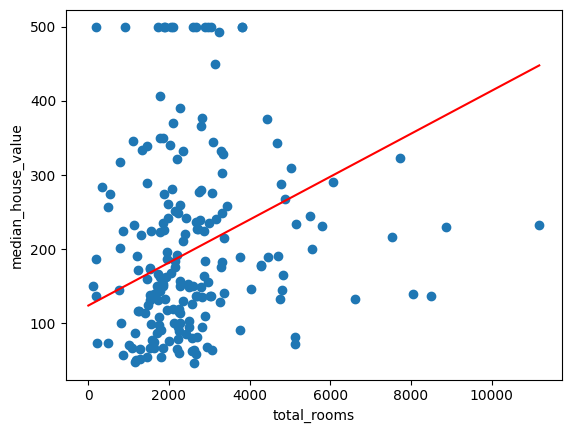

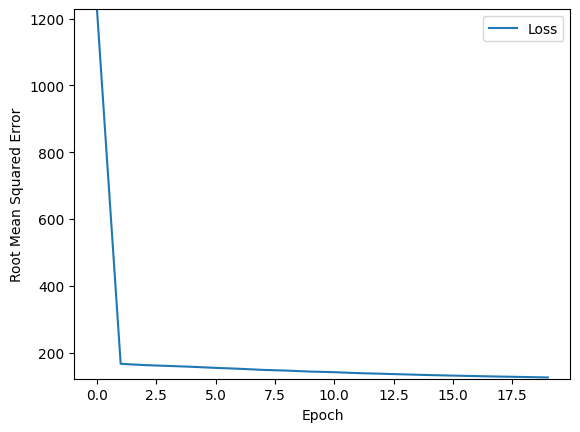

In [6]:
# Hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 20

# Feature and Label
feature = "total_rooms"
label="median_house_value"

# Remove pre-existing model
model = None

# Call functions.
model = build_and_compile_model(learning_rate)
weight, bias, epochs, rmse = train_model(model, training_df, feature, label, epochs, batch_size)

print("\nLearned weight for the model is %.4f" % weight)
print("Learned bias for the model is %.4f\n" % bias )

plot_model(weight, bias, feature, label)
plot_loss_curve(epochs, rmse)

A certain amount of randomness plays into training a model. Consequently, you'll get different results each time you train the model. That said, given the dataset and the hyperparameters, the trained model will generally do a poor job describing the feature's relation to the label.

## Use the model to make predictions

You can use the trained model to make predictions. In practice, [you should make predictions on examples that are not used in training](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). However, for this exercise, you'll just work with a subset of the same training dataset. A later Colab exercise will explore ways to make predictions on examples not used in training.

First, run the following code to define the house prediction function:

In [7]:
def house_val_pred(n, feature, label):
  """Predict house values based on a feature."""

  batch = training_df[feature][10000:10000 + n]
  predicted_vals = model.predict_on_batch(x=batch)

  print("feature\t label\t\t    predicted")
  print("  value\t value\t\t    value")
  print("         in thousand$ \t    in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f       %15.0f" % (training_df[feature][10000 + i],
                                   training_df[label][10000 + i],
                                   predicted_vals[i][0] ))

Now, invoke the house prediction function on 10 examples:

In [8]:
house_val_pred(20, feature, label)

feature	 label		    predicted
  value	 value		    value
         in thousand$ 	    in thousand$
--------------------------------------
 1960     53                   181
 3400     92                   223
 3677     69                   231
 2202     62                   188
 2403     80                   194
 5652    295                   288
 3318    500                   220
 2552    342                   198
 1364    118                   164
 3468    128                   225
 2902    187                   208
  782     80                   147
 4907    112                   266
 4164     95                   245
 2754     69                   204
 5016     90                   269
 4241     54                   247
 2260     68                   190
 2185     71                   187
 2164     73                   187


### Task 2: Judge the predictive power of the model

Look at the preceding table. How close is the predicted value to the label value?  In other words, does your model accurately predict house values?  

In [9]:
"""The predicted values do deviate significantly from the
label value, so the predictive power of the model is low."""

'The predicted values do deviate significantly from the\nlabel value, so the predictive power of the model is low.'

## Task 3: Try a different feature

The `total_rooms` feature had only a little predictive power. Would a different feature have greater predictive power?  Try using `population` as the feature instead of `total_rooms`.

Note: When you change features, you might also need to change the hyperparameters.

Epoch 1/10
3400/3400 [==============================] - 6s 2ms/step - loss: 29822.1094 - root_mean_squared_error: 172.6908
Epoch 2/10
3400/3400 [==============================] - 5s 1ms/step - loss: 20958.3789 - root_mean_squared_error: 144.7701
Epoch 3/10
3400/3400 [==============================] - 6s 2ms/step - loss: 18250.1953 - root_mean_squared_error: 135.0933
Epoch 4/10
3400/3400 [==============================] - 6s 2ms/step - loss: 17449.3457 - root_mean_squared_error: 132.0960
Epoch 5/10
3400/3400 [==============================] - 5s 1ms/step - loss: 17409.6387 - root_mean_squared_error: 131.9456
Epoch 6/10
3400/3400 [==============================] - 5s 1ms/step - loss: 17156.8828 - root_mean_squared_error: 130.9843
Epoch 7/10
3400/3400 [==============================] - 5s 2ms/step - loss: 17168.4785 - root_mean_squared_error: 131.0285
Epoch 8/10
3400/3400 [==============================] - 5s 1ms/step - loss: 17470.3066 - root_mean_squared_error: 132.1753
Epoch 9/10
3400/

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


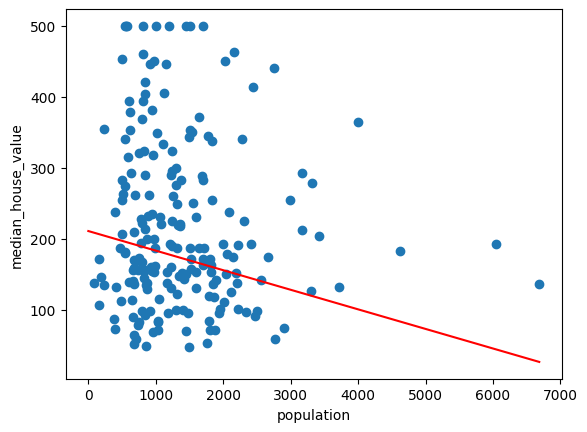

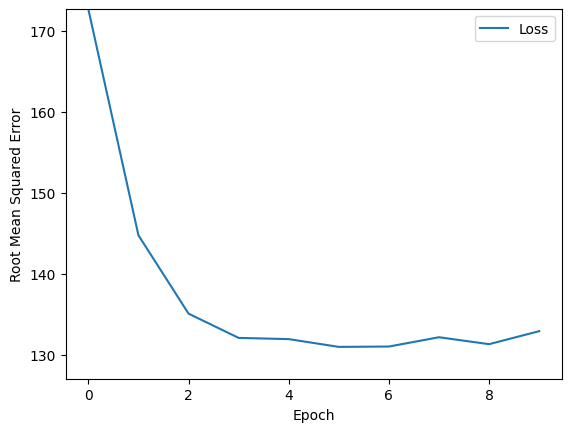

feature	 label		    predicted
  value	 value		    value
         in thousand$ 	    in thousand$
--------------------------------------
 1286     53                   176
 1867     92                   160
 2191     69                   151
 1052     62                   182
 1647     80                   166
 2312    295                   147
 1604    500                   167
 1066    342                   182
  338    118                   202
 1604    128                   167


In [12]:
feature = "population" # Pick a feature other than "total_rooms"

# Possibly, experiment with the hyperparameters.
learning_rate = 0.05
epochs = 10
batch_size = 5

# Don't change anything below.
model = build_and_compile_model(learning_rate)
weight, bias, epochs, rmse = train_model(model, training_df, feature, label, epochs, batch_size)

plot_model(weight, bias, feature, label)
plot_loss_curve(epochs, rmse)

house_val_pred(10, feature, label)

Did `population` produce better predictions than `total_rooms`?

> The predictions made with the population feature are fairly similar to the
results from the feature total_rooms. So it is not a useful feature to use.

## Task 4: Define a synthetic feature

You have determined that `total_rooms` and `population` were not useful features.  That is, neither the total number of rooms in a neighborhood nor the neighborhood's population successfully predicted the median house price of that neighborhood. Perhaps though, the *ratio* of `total_rooms` to `population` might have some predictive power. That is, perhaps block density relates to median house value.

To explore this hypothesis, do the following:

1. Create a [synthetic feature](https://developers.google.com/machine-learning/glossary/#synthetic_feature) that's a ratio of `total_rooms` to `population`. (If you are new to pandas DataFrames, please study the [Pandas DataFrame Ultraquick Tutorial](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en).)
2. Tune the three hyperparameters.
3. Determine whether this synthetic feature produces
   a lower loss value than any of the single features you
   tried earlier in this exercise.

Epoch 1/10
5667/5667 [==============================] - 13s 2ms/step - loss: 33780.4023 - root_mean_squared_error: 183.7945
Epoch 2/10
5667/5667 [==============================] - 8s 1ms/step - loss: 15984.9863 - root_mean_squared_error: 126.4317
Epoch 3/10
5667/5667 [==============================] - 9s 2ms/step - loss: 15296.2949 - root_mean_squared_error: 123.6782
Epoch 4/10
5667/5667 [==============================] - 9s 2ms/step - loss: 15526.0166 - root_mean_squared_error: 124.6034
Epoch 5/10
5667/5667 [==============================] - 8s 1ms/step - loss: 15526.7412 - root_mean_squared_error: 124.6063
Epoch 6/10
5667/5667 [==============================] - 9s 2ms/step - loss: 15519.2100 - root_mean_squared_error: 124.5761
Epoch 7/10
5667/5667 [==============================] - 9s 2ms/step - loss: 15557.8682 - root_mean_squared_error: 124.7312
Epoch 8/10
5667/5667 [==============================] - 8s 1ms/step - loss: 15552.6426 - root_mean_squared_error: 124.7102
Epoch 9/10
5667

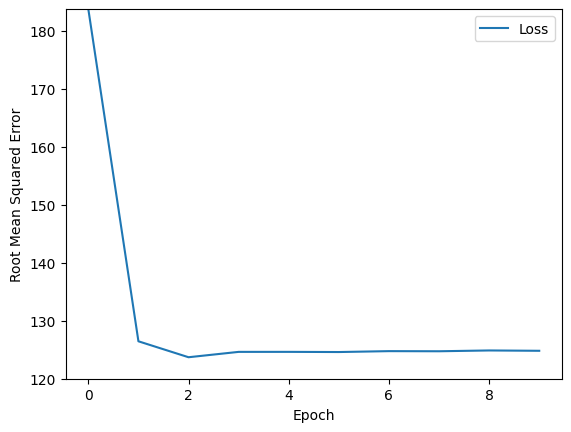

feature	 label		    predicted
  value	 value		    value
         in thousand$ 	    in thousand$
--------------------------------------
    2     53                   178
    2     92                   198
    2     69                   188
    2     62                   215
    1     80                   174
    2    295                   238
    2    500                   214
    2    342                   235
    4    118                   341
    2    128                   220
    2    187                   236
    3     80                   253
    2    112                   238
    2     95                   228
    2     69                   214


In [14]:
#@title Double-click to view a possible solution to Task 4.

# Define a synthetic feature
training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"]
feature = "rooms_per_person"

# Tune the hyperparameters.
learning_rate = 0.01
epochs = 10
batch_size = 3

# Don't change anything below this line.
model = build_and_compile_model(learning_rate)
weight, bias, epochs, mae = train_model(model, training_df,
                                        feature, label,
                                        epochs, batch_size)

plot_loss_curve(epochs, mae)
house_val_pred(15, feature, label)

Based on the loss values, this synthetic feature produces a better model than the individual features you tried in Task 2 and Task 3. However, the model still isn't creating great predictions.


## Task 5. Find feature(s) whose raw values correlate with the label

So far, we've relied on trial-and-error to identify possible features for the model.  Let's rely on statistics instead.

A **correlation matrix** indicates how each attribute's raw values relate to the other attributes' raw values. Correlation values have the following meanings:

  * `1.0`: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
  * `-1.0`: perfect negative correlation; that is, when one attribute rises, the other attribute falls.
  * `0.0`: no correlation; the two columns [are not linearly related](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).

In general, the higher the absolute value of a correlation value, the greater its predictive power. For example, a correlation value of -0.8 implies far more predictive power than a correlation of -0.2.

The following code cell generates the correlation matrix for attributes of the California Housing Dataset:

In [15]:
# Generate a correlation matrix.
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,-0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0,-0.1
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,-0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7,0.2
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.2
rooms_per_person,-0.1,0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,0.2,1.0


The correlation matrix shows nine potential features (including a synthetic
feature) and one label (`median_house_value`).  A strong negative correlation or strong positive correlation with the label suggests a potentially good feature.  

**Your Task:** Determine which of the nine potential features appears to be the best candidate for a feature?

In [16]:
"""The median income has the highest correlation with 0.7 with the label median_house_value
so it is a good feature compared to the others with close to 0 correlation."""

'The median income has the highest correlation with 0.7 with the label median_house_value\nso it is a good feature compared to the others with close to 0 correlation.'

In [ ]:
.

.

.

.

.

..

.
